In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the data from the CSV file
catdog_df = pd.read_csv('final_catdog.csv')
catdog_mouse_df = pd.read_csv('final_catdog_mouse.csv')

In [4]:
# Compute proximity scores
proximity_df = pd.DataFrame()       # Columns: Session_Id, Condition, Incumbent
sessions_to_remove = []

catdog_grouped = catdog_df.groupby('Session_Id')
catdogmouse_grouped = catdog_mouse_df.groupby('Session_Id')

# Record groups with only one row
for name, group in catdog_grouped:
    if len(group) == 1:
        sessions_to_remove.append(name)
for name, group in catdogmouse_grouped:
    if len(group) == 1:
        sessions_to_remove.append(name)
sessions_to_remove = list(set(sessions_to_remove))

# Iterate over each group. Each group has 2 rows. Compute the proximity score as mean of Connectedness of the two.
# Session_Id = group['Session_Id'].values[0]
# Condition = group['Condition'].values[0]
# Incumbent = mean of group['Connectedness'].values
for name, group in catdog_grouped:
    if name in sessions_to_remove:
        continue
    assert len(group) == 2
    proximity_df = pd.concat([proximity_df, pd.DataFrame({'Session_Id': [group['Session_Id'].values[0]], 'Condition': [group['Condition'].values[0]], 'Incumbent': [group['Connectedness'].mean()]})])
for name, group in catdogmouse_grouped:
    if name in sessions_to_remove:
        continue
    assert len(group) == 2
    # Match the session id and add group['Connectedness'].mean() to the Newcomer column of the corresponding row in proximity_df
    proximity_df.loc[proximity_df['Session_Id'] == group['Session_Id'].values[0], 'Newcomer'] = group['Connectedness'].mean()


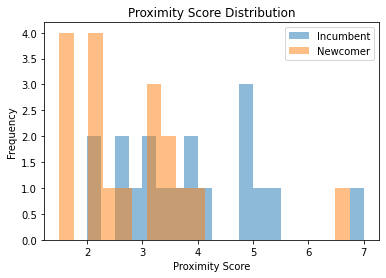

In [5]:
# Plot the histogram
incumbent = proximity_df['Incumbent'].values
newcomer = proximity_df['Newcomer'].values

plt.hist(incumbent, bins=20, alpha=0.5, label='Incumbent')
plt.hist(newcomer, bins=20, alpha=0.5, label='Newcomer')
plt.legend(loc='upper right')
plt.xlabel('Proximity Score')
plt.ylabel('Frequency')
plt.title('Proximity Score Distribution')
plt.show()

/var/folders/p3/pw0cdvjd4sd0mt4q8wywq38c0000gn/T/ipykernel_60199/2636526622.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(incumbent, label='Incumbent', shade=True)
/var/folders/p3/pw0cdvjd4sd0mt4q8wywq38c0000gn/T/ipykernel_60199/2636526622.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(newcomer, label='Newcomer', shade=True)


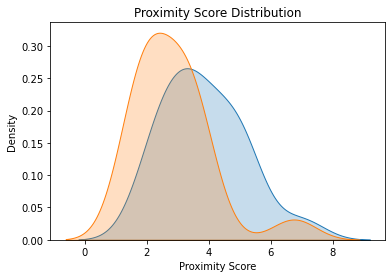

In [6]:
import seaborn as sns

# Plot kernel density estimate (smooth curve)
sns.kdeplot(incumbent, label='Incumbent', shade=True)
sns.kdeplot(newcomer, label='Newcomer', shade=True)
plt.xlabel('Proximity Score')
plt.ylabel('Density')
plt.title('Proximity Score Distribution')
plt.show()

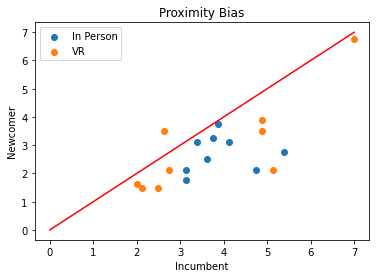

In [7]:
# Proximity bias scatter plot

# Plot y=x line
x = np.linspace(0, 7, 100)
plt.plot(x, x, color='red')

# Scatter plot of Incumbent vs Newcomer where condition = 0
plt.scatter(proximity_df[proximity_df['Condition'] == 0]['Incumbent'], proximity_df[proximity_df['Condition'] == 0]['Newcomer'], label='In Person')
# Scatter plot of Incumbent vs Newcomer where condition = 1
plt.scatter(proximity_df[proximity_df['Condition'] == 1]['Incumbent'], proximity_df[proximity_df['Condition'] == 1]['Newcomer'], label='VR')
plt.xlabel('Incumbent')
plt.ylabel('Newcomer')
plt.title('Proximity Bias')
plt.legend(loc='upper left')
plt.show()


In [8]:
# catdog_avg_df computes the mean of all columns for each session, removing the sessions with only one row
catdog_avg_df = catdog_df.groupby('Session_Id').mean().reset_index()
catdogmouse_avg_df = catdog_mouse_df.groupby('Session_Id').mean().reset_index()

# proximity_bias_df computes the ratio of catdogmouse_avg_df to catdog_avg_df
# catdogmouse_avg_df.columns = Index(['Session_Id', 'Condition', 'Connectedness', 'Comm_Effectiveness', 'Info_Exchange', 'Social_Cohesion', 'Satisfaction', 'Trust', 'Subj_Connection', 'Viability', 'Psych_Safety'], dtype='object')
proximity_bias_df = catdogmouse_avg_df.copy()
# Keep Session_Id and Condition unchanged
proximity_bias_df.drop(columns=['Session_Id', 'Condition'], inplace=True)
# Divide each column by the corresponding column in catdog_avg_df
for column in proximity_bias_df.columns:
    proximity_bias_df[column] = proximity_bias_df[column] / catdog_avg_df[column]
proximity_bias_df.rename(columns={"Connectedness":"Proximity_Bias"}, inplace=True)
# Add Session_Id and Condition back
proximity_bias_df['Session_Id'] = catdogmouse_avg_df['Session_Id']
proximity_bias_df['Condition'] = catdogmouse_avg_df['Condition'].astype(int)

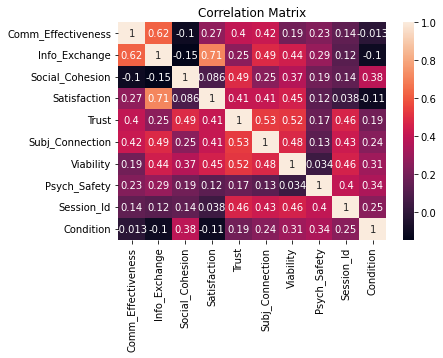

In [9]:
# Correlation matrix
corr = proximity_bias_df.drop(columns=['Proximity_Bias']).corr()
sns.heatmap(corr, annot=True)
plt.title('Correlation Matrix')
plt.show()


In [10]:
import pandas as pd

environment_df = pd.read_csv('final_catdog_evaluation.csv')
environment_df = environment_df.groupby('Session_Id').mean().reset_index()
environment_df.drop(columns=['Condition'], inplace=True)

# Merge proximity_bias_df and environment_df
merged_df = pd.merge(proximity_bias_df, environment_df, on='Session_Id')
merged_df.to_csv('merged.csv', index=False)

In [20]:
# Normalize the columns of proximity_bias_df and merged_df
copy = proximity_bias_df.copy()
copy.drop(columns=['Proximity_Bias', 'Session_Id', 'Condition'], inplace=True)
copy = (copy - copy.mean()) / copy.std()
copy['Proximity_Bias'] = proximity_bias_df['Proximity_Bias']
copy['Session_Id'] = proximity_bias_df['Session_Id']
copy['Condition'] = proximity_bias_df['Condition']
copy.to_csv('proximity_bias_normalized.csv', index=False)

In [21]:
copy = merged_df.copy()
copy.drop(columns=['Proximity_Bias', 'Session_Id', 'Condition'], inplace=True)
copy = (copy - copy.mean()) / copy.std()
copy['Proximity_Bias'] = merged_df['Proximity_Bias']
copy['Session_Id'] = merged_df['Session_Id']
copy['Condition'] = merged_df['Condition']
copy.to_csv('merged_normalized.csv', index=False)